In [1]:
%matplotlib inline

import array as arr
import binascii
import colorama
import itertools
import math
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pylab
import numpy as np
import scipy as sp
import scipy.stats
import sys

from matplotlib import cm
from colorama import Fore, Back, Style
from datetime import datetime, time, timedelta
from itertools import count # izip for maximum efficiency
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path, PureWindowsPath
from scipy import fftpack, signal
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import tukey
from scipy.stats import norm,rayleigh,skew,kurtosis
from statistics import mean
from tkinter import filedialog
from tkinter import *
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()


In [2]:
def get_file():

# Select input file - code from https://pythonspot.com/tk-file-dialogs/
    root = Tk() 
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data",\
    title = "Select .ASCII file",filetypes = (("CSV files","*.csv"),("all files","*.*")))
                                                
    root.destroy()

    return(root.filename)

In [3]:
import math

def percentile(data, percentile):
    size = len(data)
    return sorted(data)[int(math.ceil((size * percentile) / 100)) - 1]

def do_stats(df):
    p50 = percentile(df.Hsrms, 50)
    p90 = percentile(df.Hsrms, 90)
    p95 = percentile(df.Hsrms, 95)
    p99 = percentile(df.Hsrms, 99)

    print('{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}'.\
              format(np.nanmean(df.Hsrms),np.nanmedian(df.Hsrms),p90,p95,p99,max(df.Hsrms)))
    return(np.nanmean(df.Hsrms),np.nanmedian(df.Hsrms),p90,p95,p99,max(df.Hsrms))


In [4]:
def insert_breaks(x,y):
    import datetime as dtm
    import numpy    as np

    xnew = []
    ynew = []
    for dt1, dt0, y1, y0 in zip(x[1:],x[:-1],y[1:],y[:-1]):
        if dt1-dt0 <= dtm.timedelta(hours=0.5):
            xnew+=[dt0]
            ynew+=[y0]
        else:
            xnew+=[dt0,dt0+(dt1-dt0)/2]
            ynew+=[y0, np.nan]

    xnew+=[dt1]
    ynew+=[y1]

    return xnew, ynew

In [5]:
def do_calcs(df,max_val,total_time):
    
    print('{:9s}'.format('Hsrms (m)'),end=" ")
#    print('{:>9s}'.format(""), end=" ")
    for item in range(6,78,6): print('{:>6d}'.format(item), end=" ")
    print() 
    
    level = 0.25    # set initial height level
    
# Create table to hold individual values from calc's
    table = pd.DataFrame(columns=['Hs','6','12','18','24','30','36','42','48','54','60','66','72'])

    while level < max_val:
        pd.set_option('mode.chained_assignment',None)
        found = df.loc[df.Hsrms >= level].copy()
        found['Diff'] = found.index.to_series().diff().dt.total_seconds().div(3600, fill_value=0)
        level_time = sum(found.loc[found.Diff>0.5].Diff)
        Duration_band = []; Row = []
        remainder = sum(found.loc[found.Diff <= 6].Diff)/24
    #    print('Remainder = ',remainder)
        Row.append(level)

        for step in range(6,78,6):
            bin_vals = sum(found.loc[found.Diff > step].Diff)/24
    #        remainder = sum(found.loc[found.Diff <= 6].Diff)/24
            Duration_band.append(bin_vals/(total_time)*100) # get % of total hours for each time band
            Row.append(bin_vals)

        numEl = len(Row)
        newRow = pd.DataFrame(np.array(Row).reshape(1,numEl), columns = list(table.columns))
        table = table.append(newRow, ignore_index=True)

        print('{:>2s}{:<7.2f}{:>9.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}{:>7.2f}'\
              .format('< ',level,*Duration_band))

        level += 0.25

    return(table)

In [6]:
def do_joint_directions(df):
    
    old_level = 0.0
    level = 0.25

# Create table to hold individual values from calc's
    table = pd.DataFrame(columns=['Hs','337.5','22.5','67.5','112.5','157.5','202.5','247.5','292.5'])

    max_val = max(df.Hsrms)

    total_vals = df.loc[df['Pk Dir']>0]['Pk Dir'].count()
    remainder = df.loc[(df['Pk Dir']<0)]['Pk Dir'].count()
    percnt = (total_vals-remainder)
    
    print('Total values = ',total_vals)
    print('Not included = ',remainder)

    print('{:11s}'.format(' '),end=" ")
    for i in [337.5,22.5,67.5,112.5,157.5,202.5,247.5,292.5]:
        print('{:8.1f}{:1s}'.format(i,'-'),end=" ")
    print()
    print('{:10s}'.format('Hsrms (m) '),end=" ")
    for i in [337.5,22.5,67.5,112.5,157.5,202.5,247.5,292.5]:
        print('{:9.1f}'.format((i+45)%360),end=" ")
    print('    Total')
    col_tot = [0] * 10; 
    while old_level < max_val:
        Row = []
        pd.set_option('mode.chained_assignment',None)
        found = df.loc[(df.Hsrms > old_level) & (df.Hsrms <= level)].copy()

        print('{:4.2f}{:1s}{:4.2f}{:1s}'.format(old_level,'-',level,' '),end=" ")
        bin_val_sum = 0; bin_val_total = 0

        i = 0
        Row.append(level)
        for step in [22.5,67.5,112.5,157.5,202.5,247.5,292.5,337.5]:
            if (step - 45 < 0):
                bin_vals = found.loc[(found['Pk Dir'] >= step-45+360) | ((found['Pk Dir'] < step)&(found['Pk Dir'] >= 0))]['Pk Dir'].count()
            else:
                bin_vals = found.loc[(found['Pk Dir'] >= step-45) & (found['Pk Dir'] < step)]['Pk Dir'].count()

            Row.append(bin_vals/percnt*100)
            col_tot[i] = col_tot[i] + bin_vals
            i+=1
            bin_val_sum += bin_vals
            print('{:9.1f}'.format(bin_vals),end=" ")
        old_level = level
        print('{:>9.1f}'.format(bin_val_sum))
        bin_val_total += bin_val_sum
        
        numEl = len(Row)
        newRow = pd.DataFrame(np.array(Row).reshape(1,numEl), columns = list(table.columns))
        table = table.append(newRow, ignore_index=True)
        level += 0.25

    print('{:10s}'.format(''),end=" ")
    for i in range(1,9):
        print('{:9.1f}'.format(col_tot[i-1]),end=" ")
    print('{:9.1f}'.format(sum(col_tot)))
        
    return(table)

In [7]:
def do_joint_periods(df):
    max_val = max(df.Hsrms)
    old_level = 0.0
    level = 0.25
    
# Create table to hold individual values from calc's
    List=[i for i in (np.arange(9)*2+2).astype(str)]; List.insert(0, "Hs")
    table = pd.DataFrame(columns=List)
    
    total_vals = df.Tp.count()
    bin_vals = 0
    remainder = df.loc[(df.Hsrms > 4.75) | (df.Tp < 2) | (df.Tp > 25)].Tp.count()
    percnt = (total_vals-remainder)
    
    print('Total values = ',total_vals)
    print('Not included = ',remainder)
    
    print('{:11s}'.format('Hsrms (m) '),end=" ")
    for i in range(2,20,2):
        print('{:6d}{:1s}{:<2d}'.format(i,'-',i+2),end=" ")
    print('Total')
    col_tot = [0] * 10
    while old_level < max_val:
        Row = []
        pd.set_option('mode.chained_assignment',None)
        found = df.loc[(df.Hsrms > old_level) & (df.Hsrms <= level)].copy()

        print('{:4.2f}{:1s}{:4.2f}{:1s}'.format(old_level,'-',level,' '),end=" ")
        
        bin_val_total = 0; bin_val_sum = 0
        Row.append(level)
        for step in range(2,20,2):
            bin_vals = found.loc[(found.Tp >= step) & (found.Tp < step+2)].Tp.count()
            Row.append(bin_vals/percnt*100)
            col_tot[int(step/2-1)] += bin_vals
            bin_val_sum += bin_vals
            print('{:9.1f}'.format(bin_vals),end=" ")
        old_level = level
        print('{:>6.1f}'.format(bin_val_sum))
        bin_val_total += bin_val_sum
       
        numEl = len(Row)
        newRow = pd.DataFrame(np.array(Row).reshape(1,numEl), columns = list(table.columns))
        table = table.append(newRow, ignore_index=True)

        level += 0.25

    print('{:10s}'.format(''),end=" ")
    for i in range(9):
        print('{:9.1f}'.format(col_tot[i]),end=" ")
    print('{:6.1f}'.format(sum(col_tot)))
    
    return(table)

In [8]:
def do_heatmap_main(table):

    Heights = table.iloc[0:table.shape[0],0].values
    Durations = table.columns[1:].values

    table1 = table.mul(1/max(table.max())*100)
    Duration_table = table1.iloc[0:,1:table1.shape[1]].values


    fig, ax = plt.subplots(figsize=(15,10))

    cmap = cm.cool
    cmap.set_under(color = 'white')
    cmap.set_over(color = 'white')
    im = ax.imshow(Duration_table, cmap=cmap, clim=(0.01,75), interpolation='nearest', aspect='auto')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(Durations)))
    ax.set_yticks(np.arange(len(Heights)))

    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xlabel('Duration (Hours)')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Hsrms (m)')

    # ... and label them with the respective list entries
    ax.set_xticklabels(">"+Durations)
    ax.set_yticklabels(["<"+i for i in Heights.astype(str)])  ##"<"+str(Heights))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(Heights)):
        for j in range(len(Durations)):
            text = ax.text(j, i, "%.2f" % Duration_table[i, j],fontsize=14,style='italic',ha="center", va="center", color="b")

    ax.set_title("Hsrms persistence non-exceedance (%)",fontsize=16,y=-0.05)
    
    sigma = 0.1 # this depends on how noisy your data is, play with it!
    smoothed_data = gaussian_filter(Duration_table, sigma)

    ax.contour(smoothed_data, colors="B", levels=(10,20,30,40,50,60,70,80,90))
#    clb = plt.colorbar(im)
#    clb.ax.set_title('%')

    fig.tight_layout()
    plt.show()
    
    return()    # do_heatmap()

In [9]:
def do_heatmap_directions(table):

    Heights = table.iloc[0:table.shape[0],0].values
    Durations = table.columns[1:].values

##    table1 = table.mul(1/max(table.max())*100)
    table1 = table
    Duration_table = table1.iloc[0:,1:table1.shape[1]].values


    fig, ax = plt.subplots(figsize=(15,10))

    cmap = cm.cool
    cmap.set_under(color = 'white')
    im = ax.imshow(Duration_table, cmap=cmap, clim=(0.01,100), interpolation='nearest', aspect='auto')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(Durations)))
    ax.set_yticks(np.arange(len(Heights)))

    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xlabel(r'Peak direction ($^o$)')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Hsrms (m)')

    # ... and label them with the respective list entries
    ax.set_xticklabels(Durations)
    ax.set_yticklabels(Heights.astype(str))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(Heights)):
        for j in range(len(Durations)):
            text = ax.text(j, i, "%.2f" % Duration_table[i, j],fontsize=14,style='italic',ha="center", va="center", color="b")

    ax.set_title("Hsrms vs peak wave direction",fontsize=16,y=-0.05)
    
    sigma = 0.1 # this depends on how noisy your data is, play with it!
    smoothed_data = gaussian_filter(Duration_table, sigma)

    ax.contour(smoothed_data, colors="B", levels=(0.01,1,2,5,10,20,50))
#    clb = plt.colorbar(im)
#    clb.ax.set_title('%')

    fig.tight_layout()
    plt.show()
     
    return()    # do_heatmap_directions()

In [10]:
def do_heatmap_periods(table):

    Heights = table.iloc[0:table.shape[0],0].values
    Durations = table.columns[1:].values

    ##    table1 = table.mul(1/max(table.max())*100)
    table1 = table
    Duration_table = table1.iloc[0:,1:table1.shape[1]].values


    fig, ax = plt.subplots(figsize=(15,10))

    cmap = cm.cool
    cmap.set_under(color = 'white')
    im = ax.imshow(Duration_table, cmap=cmap, clim=(0.01,100), interpolation='nearest', aspect='auto')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(Durations)))
    ax.set_yticks(np.arange(len(Heights)))

    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xlabel('Peak period (s)')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Hsrms (m)')

    # ... and label them with the respective list entries
    ax.set_xticklabels(Durations)
    ax.set_yticklabels(Heights.astype(str))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(Heights)):
        for j in range(len(Durations)):
            text = ax.text(j, i, "%.2f" % Duration_table[i, j],fontsize=14,style='italic',ha="center", va="center", color="b")

    ax.set_title("Hsrms vs peak wave period",fontsize=16,y=-0.05)

    sigma = 0.1 # this depends on how noisy your data is, play with it!
    smoothed_data = gaussian_filter(Duration_table, sigma)

    ax.contour(smoothed_data, colors="B", levels=(0.01,1,2,5,10,20,50))
#    clb = plt.colorbar(im)
#    clb.ax.set_title('%')

    fig.tight_layout()
    plt.show()
    
    return()    # do_heatmap_periods()

In [11]:
def do_plot(df,plot_title):

    import matplotlib.patches as mpatches
    import matplotlib.dates as mdates
    
    df.iat[0,0] = df.iat[1,0]; df.iat[len(df)-1,0] = df.iat[len(df)-2,0]
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    ax.set_ylim([0,max(df.Hsrms)])

# do plots for each range of heights    
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms<=0.25)].index,df.loc[(df.Hsrms<=0.25)].Hsrms); 
        ax.plot(x,y,'r',lw=0)
        L0 = ax.fill_between(x, 0.25, y,facecolor='green')
    except:
        pass
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms>=0.25)].index,df.loc[(df.Hsrms>=0.25)].Hsrms); ax.plot(x,y,'lightgreen',lw=0)
        L1 = ax.fill_between(x, 0.25, y,facecolor='lightgreen')
    except:
        pass
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms>=0.5)].index,df.loc[(df.Hsrms>=0.5)].Hsrms); ax.plot(x,y,'lightblue',lw=0)
        L2 = ax.fill_between(x, 0.5, y,facecolor='lightblue')
    except:
        pass
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms>=0.75)].index,df.loc[(df.Hsrms>=0.75)].Hsrms); ax.plot(x,y,'blue',lw=0)
        L3 = ax.fill_between(x, 0.75, y,facecolor='blue')
    except:
        pass
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms>=1)].index,df.loc[(df.Hsrms>=1)].Hsrms); ax.plot(x,y,'yellow',lw=0)
        L4 = ax.fill_between(x, 1.0, y,facecolor='yellow')
    except:
        pass
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms>=2)].index,df.loc[(df.Hsrms>=2)].Hsrms); ax.plot(x,y,'pink',lw=0)
        L5 = ax.fill_between(x, 2.0, y,facecolor='pink')
    except:
        pass
    try:
        x,y = insert_breaks(df.loc[(df.Hsrms>=3)].index,df.loc[(df.Hsrms>=3)].Hsrms); ax.plot(x,y,'red',lw=0)
        L6 = ax.fill_between(x, 3.0, y,facecolor='red')
    except:
        pass
    

# create color patches for the legend
    green_patch = mpatches.Patch(color='green', label='< 0.25')
    lightgreen_patch = mpatches.Patch(color='lightgreen', label='0.25-0.50')
    lightblue_patch = mpatches.Patch(color='lightblue', label='0.50-0.75')
    blue_patch = mpatches.Patch(color='blue', label='0.75-1.00')
    yellow_patch = mpatches.Patch(color='yellow', label='1.00-2.00')
    pink_patch = mpatches.Patch(color='pink', label='2.00-3.00')
    red_patch = mpatches.Patch(color='red', label='> 3.0')
    
    plt.legend(handles=[red_patch,pink_patch,yellow_patch,blue_patch,lightblue_patch,lightgreen_patch,green_patch],frameon=False)
    
# apply fix to date axis to make it more readable    
    if (plot_title != 'All data'):
        days = mdates.DayLocator()   # every day
        days_fmt = mdates.DateFormatter('%d')
        ax.xaxis.set_major_formatter(days_fmt)

        ax.format_xdata = mdates.DateFormatter('%d')
        ax.set_xlabel(plot_title)
    else:
        ax.set_title(plot_title,fontsize=12)

    ax.grid(True)
    
    plt.show()
    return()

Total number of days available =  175.23 days.
Number of gaps in data =   0.00 days.
All data
Hsrms (m)      6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25        9.26   3.90   1.88   1.45   0.86   0.86   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       65.13  64.13  61.85  58.00  56.06  56.06  54.24  52.07  52.07  52.07  49.03  47.41
< 0.75       80.00  79.85  79.53  79.53  79.53  79.53  79.53  79.53  79.53  79.53  79.53  79.53
< 1.00       83.68  83.68  83.68  83.21  83.21  83.21  82.36  82.36  82.36  82.36  82.36  82.36
< 1.25       87.33  87.09  86.71  86.18  86.18  86.18  86.18  86.18  86.18  86.18  86.18  86.18
< 1.50       88.38  87.94  87.94  87.94  87.94  87.94  87.94  87.94  87.94  87.94  87.94  87.94
< 1.75       90.44  90.22  89.83  89.39  88.80  88.80  88.80  88.80  88.80  88.80  88.80  88.80
< 2.00       92.27  92.11  92.11  92.11  91.48  91.48  91.48  91.48  91.48  91.48  91.48  91.48
< 2.25       94.28  94.06  93.69  93.19  93

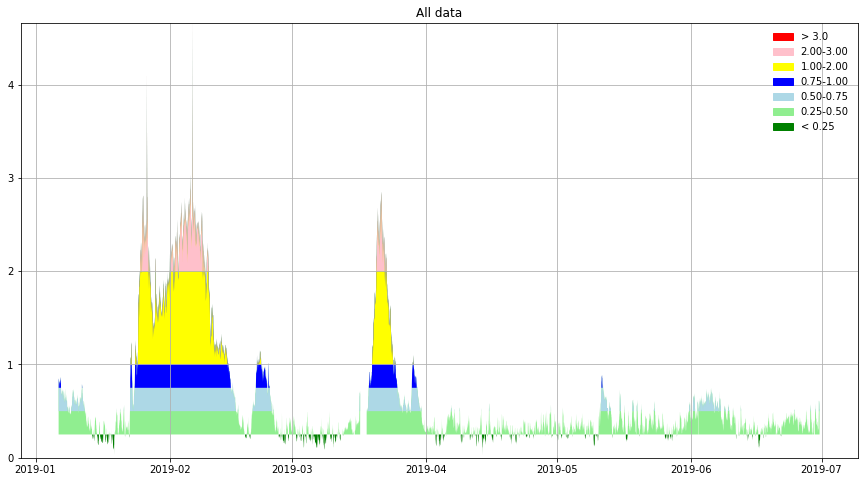


January
Hsrms (m)      6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25       10.63   4.95   2.92   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       39.45  38.15  32.95  32.95  28.17  28.17  28.17  28.17  28.17  28.17  28.17  28.17
< 0.75       64.12  64.12  61.93  61.93  61.93  61.93  61.93  61.93  61.93  61.93  61.93  61.93
< 1.00       67.78  67.78  67.78  64.61  64.61  64.61  64.61  64.61  64.61  64.61  64.61  64.61
< 1.25       71.35  71.35  68.75  68.75  68.75  68.75  68.75  68.75  68.75  68.75  68.75  68.75
< 1.50       72.97  71.51  71.51  71.51  71.51  71.51  71.51  71.51  71.51  71.51  71.51  71.51
< 1.75       82.71  81.17  78.57  75.57  71.51  71.51  71.51  71.51  71.51  71.51  71.51  71.51
< 2.00       89.61  89.61  89.61  89.61  85.31  85.31  85.31  85.31  85.31  85.31  85.31  85.31
< 2.25       93.34  93.34  93.34  93.34  93.34  93.34  93.34  93.34  93.34  93.34  93.34  93.34
< 2.50       98.05  95.37  95.37

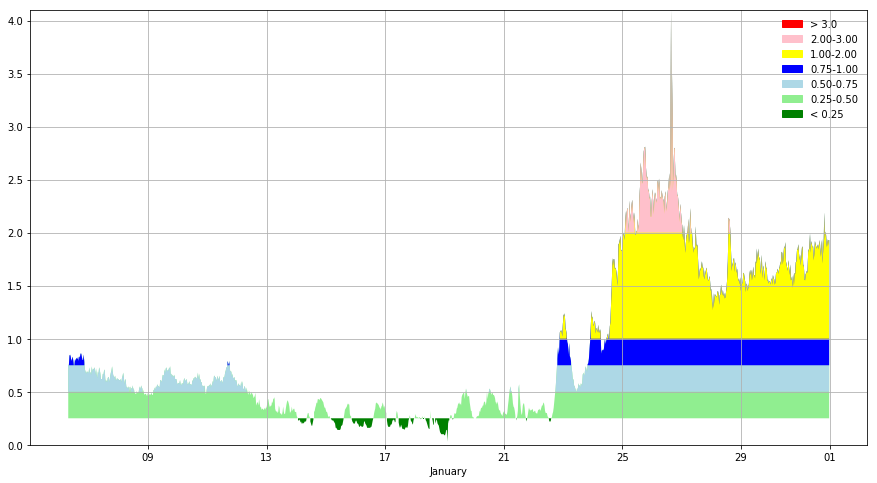


February
Hsrms (m)      6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25        4.10   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       26.36  26.36  26.36  26.36  26.36  26.36  26.36  26.36  26.36  26.36  26.36  26.36
< 0.75       37.75  36.78  36.78  36.78  36.78  36.78  36.78  36.78  36.78  36.78  36.78  36.78
< 1.00       47.80  47.80  47.80  47.80  47.80  47.80  42.44  42.44  42.44  42.44  42.44  42.44
< 1.25       62.62  61.13  61.13  57.86  57.86  57.86  57.86  57.86  57.86  57.86  57.86  57.86
< 1.50       66.05  64.63  64.63  64.63  64.63  64.63  64.63  64.63  64.63  64.63  64.63  64.63
< 1.75       67.46  67.46  67.46  67.46  67.46  67.46  67.46  67.46  67.46  67.46  67.46  67.46
< 2.00       69.55  68.50  68.50  68.50  68.50  68.50  68.50  68.50  68.50  68.50  68.50  68.50
< 2.25       75.73  74.31  72.00  68.88  68.88  68.88  68.88  68.88  68.88  68.88  68.88  68.88
< 2.50       87.64  83.92  79.6


March
Hsrms (m)      6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25       21.59  14.12   8.20   8.20   4.84   4.84   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       58.71  58.71  58.71  58.71  55.14  55.14  50.30  50.30  50.30  50.30  50.30  50.30
< 0.75       74.18  74.18  74.18  74.18  74.18  74.18  74.18  74.18  67.65  67.65  67.65  67.65
< 1.00       81.57  81.57  81.57  81.57  81.57  81.57  81.57  81.57  81.57  81.57  81.57  72.16
< 1.25       85.88  85.88  85.88  85.88  85.88  85.88  85.88  85.88  85.88  85.88  85.88  85.88
< 1.50       87.42  87.42  87.42  87.42  87.42  87.42  87.42  87.42  87.42  87.42  87.42  87.42
< 1.75       89.71  89.71  89.71  89.71  89.71  89.71  89.71  89.71  89.71  89.71  89.71  89.71
< 2.00       92.47  92.47  92.47  92.47  92.47  92.47  92.47  92.47  92.47  92.47  92.47  92.47
< 2.25       94.49  94.49  94.49  94.49  94.49  94.49  94.49  94.49  94.49  94.49  94.49  94.49
< 2.50       96.77  96.77  96.77  

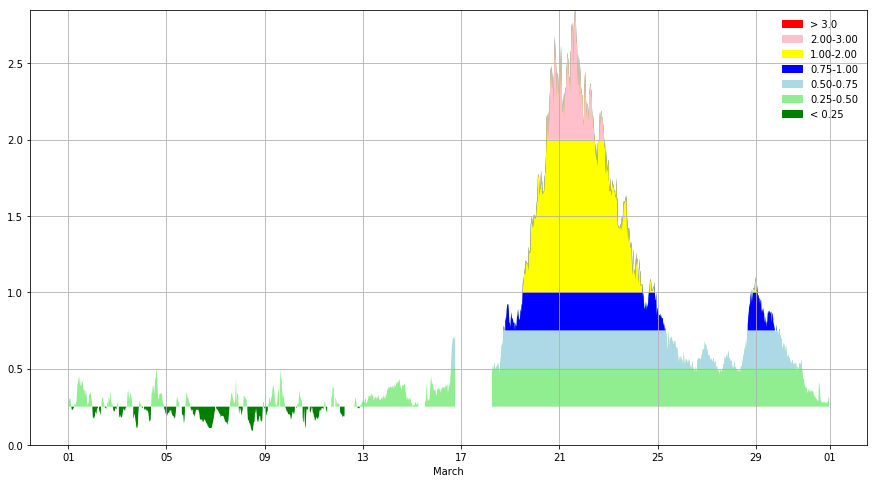


April
Hsrms (m)      6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25       10.42   3.96   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       97.98  97.98  95.90  95.90  88.67  84.43  84.43  78.46  78.46  78.46  78.46  78.46



May
Hsrms (m)      6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25        5.51   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       86.42  84.53  82.31  71.69  71.69  67.18  67.18  60.73  60.73  60.73  60.73  51.58
< 0.75       98.72  98.72  98.72  98.72  98.72  98.72  98.72  98.72  98.72  98.72  98.72  98.72


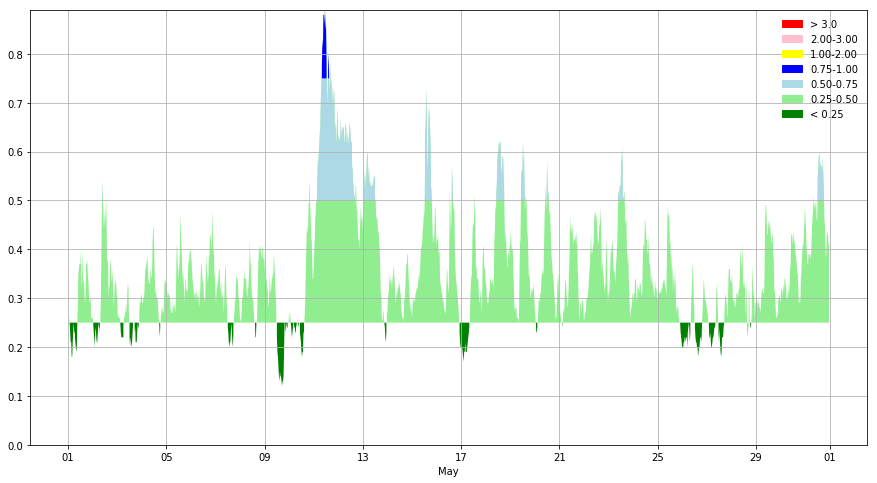


June
Hsrms (m)      6     12     18     24     30     36     42     48     54     60     66     72 
< 0.25        2.82   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00
< 0.50       74.47  70.31  67.84  56.14  56.14  56.14  50.42  50.42  50.42  50.42  41.47  41.47


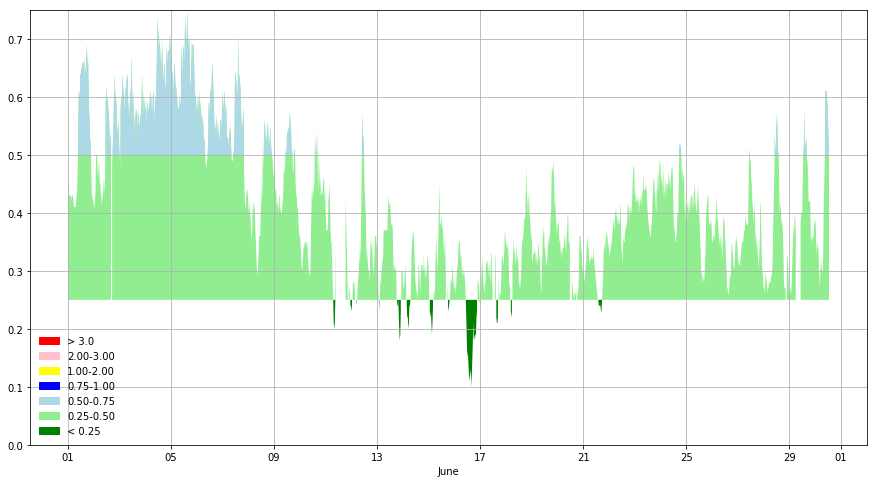

 Period         Mean  Median   P90    P95    P99    Max
All data        0.62   0.37   0.50   0.71   2.15   4.66
   January    0.87   0.58   1.93   2.27   2.56   4.10
  February    1.21   1.01   2.47   2.56   2.74   4.66
     March    0.66   0.38   1.65   2.19   2.57   2.85
     April    0.30   0.29   0.41   0.45   0.53   0.58
       May    0.36   0.33   0.52   0.61   0.75   0.89
      June    0.41   0.39   0.42   0.45   0.52   0.75
Total values =  8217
Not included =  0
               337.5-     22.5-     67.5-    112.5-    157.5-    202.5-    247.5-    292.5- 
Hsrms (m)       22.5      67.5     112.5     157.5     202.5     247.5     292.5     337.5     Total
0.00-0.25       49.0      76.0     347.0     297.0     158.0     120.0     223.0      80.0    1350.0
0.25-0.50       80.0     225.0    1266.0     699.0     284.0     762.0     606.0     226.0    4148.0
0.50-0.75        3.0       2.0     117.0      37.0       7.0     330.0     488.0     150.0    1134.0
0.75-1.00        0.0       1

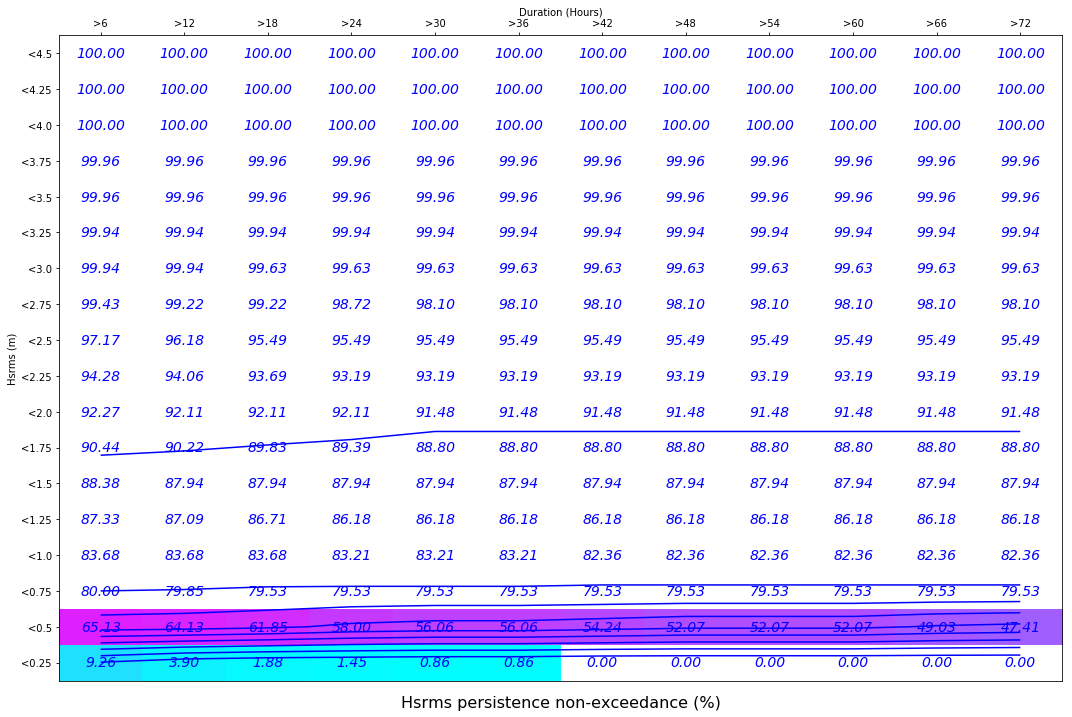

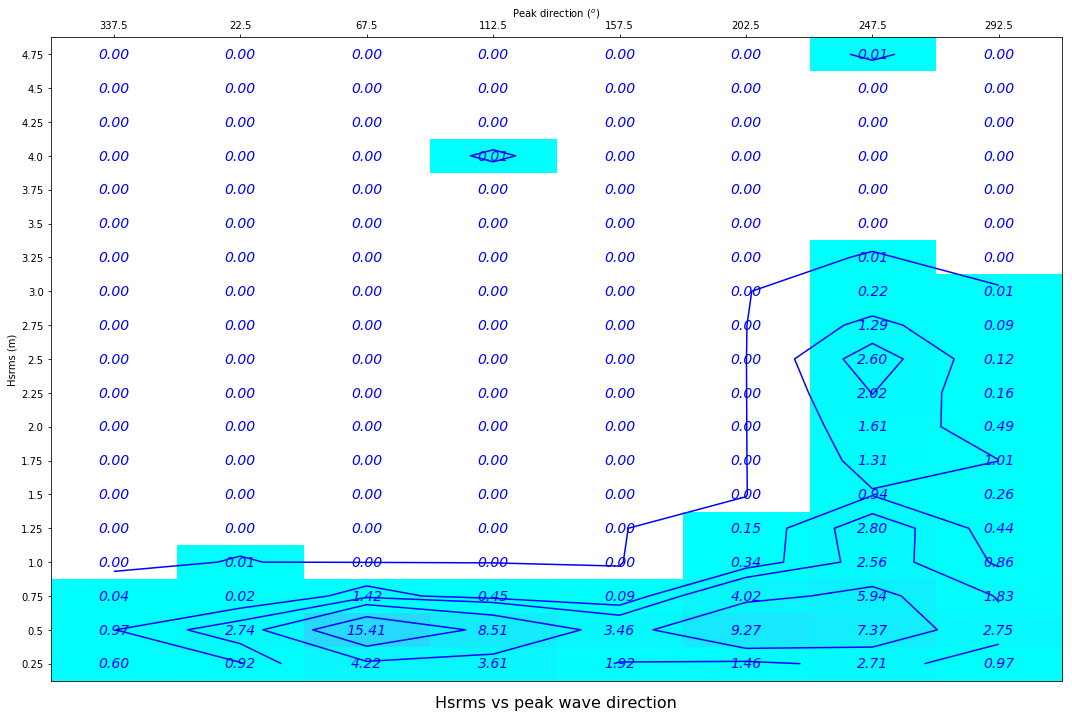

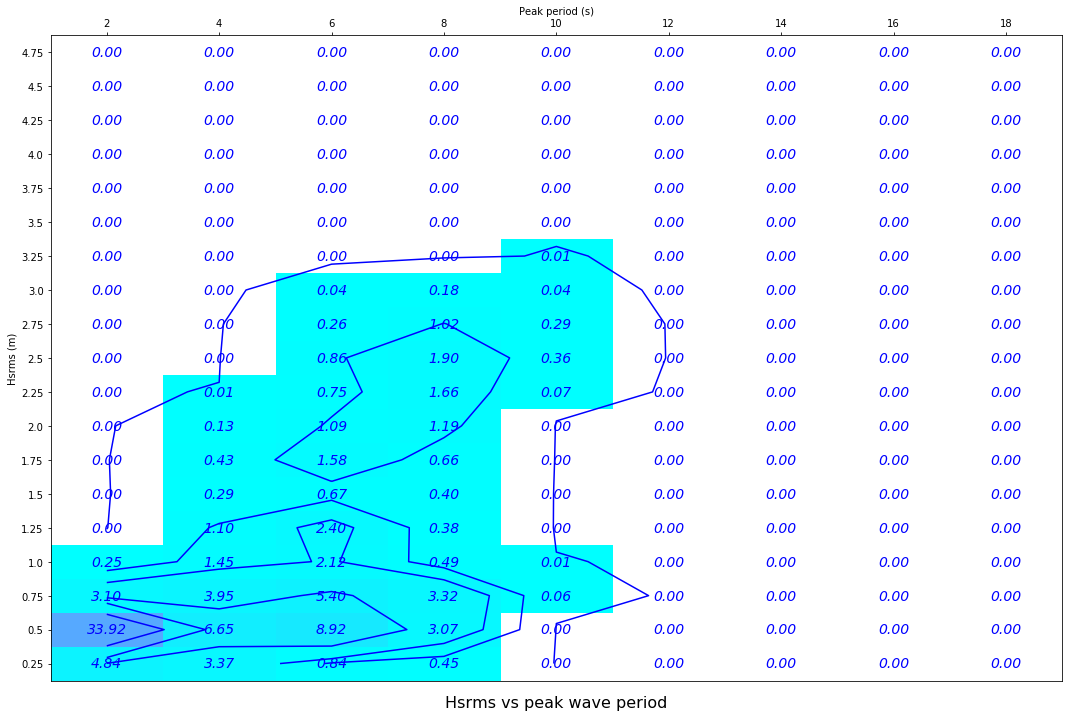

()

In [12]:
###################################
###         Main Program        ###
###################################

# Get name of input file
Input_ASCII_File = get_file()

# Read data from file into dataframe
try:
    df = pd.read_csv(Input_ASCII_File, names=['Date', 'Hsrms', 'Hmax', 'Tz', 'Tp', 'Pk Dir', 'SST'],
            parse_dates=['Date'], date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%Y %H:%M'),
            header=None, sep=',',engine='python')
except:
    df = pd.read_csv(Input_ASCII_File, names=['Date', 'Hsrms', 'Hmax', 'Tz', 'Tp', 'Pk Dir', 'SST'],
            parse_dates=['Date'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'),
            skiprows=1, sep=',',engine='python')

# Convert Hsrms, Tp, and PkDir data fron string values to floats
df['Hsrms'] = pd.to_numeric(df['Hsrms'],errors='coerce')
df['Tp'] = pd.to_numeric(df['Tp'],errors='coerce')
df['Pk Dir'] = pd.to_numeric(df['Pk Dir'],errors='coerce')

# set up list of months
months = np.unique(df.Date.dt.month.values).tolist()
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']
df.set_index('Date',inplace=True)

# Index the dataframe on dates
df.index = pd.to_datetime(df.index)

# Find time difference (in hours) between consecutive rows in dataframe 
df['Diff'] = df.index.to_series().diff().dt.total_seconds().div(3600, fill_value=0)

# Make a copy of original dataframe for initial plotting purposes
df_2 = df.copy()

# locate the maximum Hsrms value in dataframe
# This will be limit of iteration levels in vertical axis, and limit of gaps in time axis
max_val = float(max(df.Hsrms))

# Set first and last Hsrms values to the maximum 
df.iat[0,0]= max_val; df.iat[len(df)-1,0]= max_val
df.update(df)
level = 0.25

total_time = (df.index[-1:] - df.index[:1]).total_seconds().values[0]/86400
print('Total number of days available = ',end=" ")
print('{:>5.2f}{:<6s}'.format(total_time,' days.'))

# Remove gaps from original DF
df_1 = df.loc[df.Diff < 6].copy() # ignore values where gap > 2 hours exist
df_1['Diff'] = df_1.index.to_series().diff().dt.total_seconds().div(3600, fill_value=0)
total_time_df1 = (df_1.index[-1:] - df_1.index[:1]).total_seconds().values[0]/86400
print('Number of gaps in data = ',end=" ")
print('{:>5.2f}{:<6s}'.format(sum(df.loc[df.Diff > 0.5].Diff)/24,' days.'))

# Do calcs and plots for all data
print('All data')
table = do_calcs(df,max_val,total_time)
do_plot(df_1,'All data')

# Do calcs and plots for individual months
for i in months:
    print()
    print(month_names[i-1])
    df1 = df_2.loc[pd.DatetimeIndex(df_2.index).month == i]
    total_time = (df1.index[-1:] - df1.index[:1]).total_seconds().values[0]/86400
    max_val = float(max(df1.Hsrms))
    df1.iat[0,0]= max_val; df1.iat[len(df1)-1,0]= max_val
    do_calcs(df1,max_val,total_time)
    do_plot(df1,month_names[i-1])
    
print('{:<12s}{:10s}{:>3s}{:>6s}{:>7s}{:>7s}{:>7s}'.format(' Period','    Mean','Median','P90','P95','P99','Max'))
print('{:12s}'.format('All data'),end=" ")
do_stats(df_1)

for i in months:
    print('{:>10}'.format(month_names[i-1]),end=" ")
    df1 = df_2.loc[pd.DatetimeIndex(df_2.index).month == i]
    do_stats(df1)

# Do joint probability of directions and periods for all data
df_1 = df_2.copy()
direction_table = do_joint_directions(df_1)
df_1 = df_2.copy()
period_table = do_joint_periods(df_1)
do_heatmap_main(table)
do_heatmap_directions(direction_table)
do_heatmap_periods(period_table)